In [98]:
from __future__ import print_function, division

import pandas as pd
import geopandas as gpd
import fiona
import shapely
import choroplethNYC.choroplethNYC as cp

pd.options.display.max_columns = 999

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Tree Counts and Perceived Safety

In [2]:
ss = pd.read_csv('data/streetscore_newyorkcity.csv')
ts = pd.read_csv('data/2015_Street_Tree_Census_-_Tree_Data.csv')

In [3]:
ss.head()

,latitude,longitude,q-score
0,40.700909,-74.013504,11.062166
1,40.701000,-74.013878,10.818611
2,40.701080,-74.012878,12.677955
3,40.701187,-74.013268,11.417325
4,40.701244,-74.012115,25.199091


In [4]:
ts.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,zipcode,zip_city,cb_num,borocode,boroname,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,None,None,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,147-074 7 AVENUE,11357,Whitestone,407,4,Queens,19,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,Damage,Volunteer,None,No,No,No,No,No,No,No,No,No,390 MORGAN AVENUE,11211,Brooklyn,301,3,Brooklyn,34,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,1027 GRAND STREET,11211,Brooklyn,301,3,Brooklyn,34,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,603 6 STREET,11215,Brooklyn,306,3,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,990913.775,182202.4260


## Geojson of NYC blocks

In [5]:
blocks = gpd.GeoDataFrame.from_file("data/2010 Census Blocks.geojson")

In [6]:
# Number of NYC blocks
len(blocks)

38794

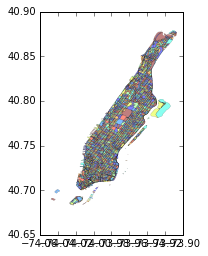

In [95]:
blocks[blocks.boro_name=='Manhattan'].plot(linewidth=0.1)

## Creating points for each tree

In [8]:
ts.dropna(axis=0, subset=['latitude','longitude'], inplace=True)
ts['lonlat'] = zip(ts.longitude, ts.latitude)
ts['geometry'] = ts[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [9]:
#Adding coordinate reference system to each dataframe
ts.crs = {'init': 'epsg:4326'}
blocks.crs = {'init': 'epsg:4326'}
ss.crs = {'init': 'epsg:4326'}

In [10]:
ts.head()

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,zipcode,zip_city,cb_num,borocode,boroname,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,lonlat,geometry
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,"(-73.84421522, 40.72309177)",POINT (-73.84421522 40.72309177)
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,None,None,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,147-074 7 AVENUE,11357,Whitestone,407,4,Queens,19,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,"(-73.81867946, 40.79411067)",POINT (-73.81867946 40.79411067)
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,Damage,Volunteer,None,No,No,No,No,No,No,No,No,No,390 MORGAN AVENUE,11211,Brooklyn,301,3,Brooklyn,34,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,"(-73.9366077, 40.71758074)",POINT (-73.93660770000001 40.71758074)
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,1027 GRAND STREET,11211,Brooklyn,301,3,Brooklyn,34,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,"(-73.93445616, 40.71353749)",POINT (-73.93445616 40.71353749)
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,603 6 STREET,11215,Brooklyn,306,3,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,"(-73.97597938, 40.66677776)",POINT (-73.97597938 40.66677776)


In [11]:
# Number of NYC trees
len(ts)

683788

## Join trees onto block polygons

In [12]:
trees_within_blocks = gpd.sjoin(ts, blocks, how="inner", op='within')

In [13]:
# Number of trees per block
tree_count = trees_within_blocks.groupby('bctcb_2010')['tree_id'].count().to_frame()

In [14]:
tree_count.head()

,tree_id
bctcb_2010,
10002011000,10
10002011001,28
10002012000,2
10002012001,30
10002021000,7


In [15]:
trees_block = pd.merge(trees_within_blocks, tree_count, how='left', left_on='bctcb_2010', right_index=True, suffixes=('_', '_y'))

## Creating points for each MIT street score

In [16]:
ss.dropna(axis=0, subset=['latitude','longitude'], inplace=True)
ss['lonlat'] = zip(ss.longitude, ss.latitude)
ss['geometry'] = ss[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [17]:
scores_within_blocks = gpd.sjoin(ss, blocks, how="inner", op='within')

In [18]:
# Finding median MIT score for each block
score_by_block = scores_within_blocks.groupby('bctcb_2010')['q-score'].median().to_frame()

In [19]:
score_by_block.head()

,q-score
bctcb_2010,
10002011000,31.161489
10002011001,22.838888
10002012000,25.675308
10002012001,23.598220
10002012002,29.116226


## Joining MIT score onto tree + block dataframe

In [20]:
trees_block_score = pd.merge(trees_block, score_by_block, how='left', left_on='bctcb_2010', right_index=True, suffixes=('_trees', '_score'))
trees_block_score.rename(columns={'tree_id_y':'tree_count','q-score':'q_score'},inplace=True)

In [21]:
no_dup = trees_block_score[['boro_name','zipcode','nta_name','bctcb_2010','tree_count','q_score']].drop_duplicates()
no_dup.dropna(inplace=True)
no_dup.head()

,boro_name,zipcode,nta_name,bctcb_2010,tree_count,q_score
604928,Staten Island,10301,West New Brighton-New Brighton-St. George,50009001000,30,26.654669
187281,Staten Island,10305,Stapleton-Rosebank,50020011000,21,24.946515
228187,Staten Island,10304,Stapleton-Rosebank,50027001000,13,22.282650
161121,Staten Island,10304,Grymes Hill-Clifton-Fox Hills,50040001000,19,22.888495
203577,Staten Island,10305,Grasmere-Arrochar-Ft. Wadsworth,50064001000,12,23.437673


In [22]:
by_zip = no_dup.groupby('zipcode')['tree_count'].mean()

## Correlation between perceived safety and tree count

In [87]:
from scipy.stats import pearsonr, spearmanr

pearsonr(no_dup['tree_count'],no_dup['q_score'])

(0.22322704989148948, 0.0)

In [88]:
spearmanr(no_dup['tree_count'],no_dup['q_score'])

SpearmanrResult(correlation=0.3068341575896355, pvalue=0.0)

In [83]:
boros = no_dup.boro_name.unique()
for boro in boros:
    boro_df = no_dup[no_dup.boro_name==boro]
    corr = spearmanr(boro_df['tree_count'],boro_df['q_score'])
    print('{}: {}'.format(boro,corr[0]))

Staten Island: 0.196200189855
Manhattan: 0.252397701805
Brooklyn: 0.373834857622
Bronx: 0.233357069721
Queens: 0.364571744522


Correlation seems to vary significantly based on the borough with Brooklyn and Queens a ~0.37 positive correlation between safety and tree count.

## Investigating by zip code

In [25]:
zipcodes = no_dup.zipcode.unique()

In [26]:
corr_by_zip = pd.DataFrame.from_dict({zipcode: pearsonr(no_dup[no_dup.zipcode == zipcode]['tree_count'],no_dup[no_dup.zipcode == zipcode]['q_score'])[0] for zipcode in zipcodes},orient='index').rename(columns={0:'corr'})
trees_by_zip = no_dup.groupby('zipcode')['tree_count'].mean().to_frame()
corr_trees_by_zip = pd.concat([corr_by_zip,trees_by_zip], axis=1)

/Users/lizkalina/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:2975: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/Users/lizkalina/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:2985: RuntimeWarning: invalid value encountered in double_scalars
  prob = _betai(0.5*df, 0.5, df/(df+t_squared))


In [27]:
corr_trees_by_zip.head()

,corr,tree_count
83,-0.449244,50.400000
10001,-0.313848,15.101449
10002,0.006931,13.852761
10003,0.184699,20.400000
10004,0.152990,9.909091


In [28]:
# Merge zip code level data with overall tree dataframe
trees_zip = pd.merge(no_dup, corr_trees_by_zip, how='left', left_on='zipcode', right_index=True, suffixes=('', '_by_zip'))

In [29]:
trees_zip.head()

,boro_name,zipcode,nta_name,bctcb_2010,tree_count,q_score,corr,tree_count_by_zip
604928,Staten Island,10301,West New Brighton-New Brighton-St. George,50009001000,30,26.654669,0.157839,21.426573
187281,Staten Island,10305,Stapleton-Rosebank,50020011000,21,24.946515,0.083168,18.391076
228187,Staten Island,10304,Stapleton-Rosebank,50027001000,13,22.282650,0.107697,19.573718
161121,Staten Island,10304,Grymes Hill-Clifton-Fox Hills,50040001000,19,22.888495,0.107697,19.573718
203577,Staten Island,10305,Grasmere-Arrochar-Ft. Wadsworth,50064001000,12,23.437673,0.083168,18.391076


In [31]:
zip_mean_score = no_dup.groupby('zipcode')['q_score'].mean().to_frame()
score_tree_zip = pd.merge(trees_zip, zip_mean_score, how='left', left_on='zipcode', right_index=True, suffixes=('', '_by_zip'))

In [33]:
score_tree_zip.head()

,boro_name,zipcode,nta_name,bctcb_2010,tree_count,q_score,corr,tree_count_by_zip,q_score_by_zip
604928,Staten Island,10301,West New Brighton-New Brighton-St. George,50009001000,30,26.654669,0.157839,21.426573,24.930318
187281,Staten Island,10305,Stapleton-Rosebank,50020011000,21,24.946515,0.083168,18.391076,23.725939
228187,Staten Island,10304,Stapleton-Rosebank,50027001000,13,22.282650,0.107697,19.573718,25.101966
161121,Staten Island,10304,Grymes Hill-Clifton-Fox Hills,50040001000,19,22.888495,0.107697,19.573718,25.101966
203577,Staten Island,10305,Grasmere-Arrochar-Ft. Wadsworth,50064001000,12,23.437673,0.083168,18.391076,23.725939


In [146]:
by_zip = score_tree_zip[['zipcode','boro_name','tree_count_by_zip','q_score_by_zip','corr']].drop_duplicates().reset_index()
by_zip.head()

,index,zipcode,boro_name,tree_count_by_zip,q_score_by_zip,corr
0,604928,10301,Staten Island,21.426573,24.930318,0.157839
1,187281,10305,Staten Island,18.391076,23.725939,0.083168
2,228187,10304,Staten Island,19.573718,25.101966,0.107697
3,247117,10306,Staten Island,21.540453,24.854738,0.158706
4,86345,10310,Staten Island,17.317536,24.527829,0.104470


## Import NYC shapefile

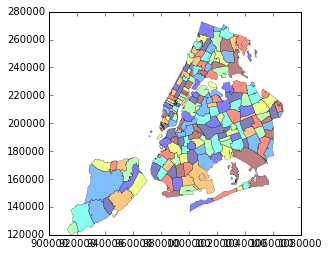

In [147]:
zip_map = gpd.read_file('data/ZIP_CODE_040114/ZIP_CODE_040114.shp')
zip_map['zipcode'] = zip_map['ZIPCODE'].apply(lambda x: int(x))
zip_map.plot(linewidth=0.2)

In [155]:
# Merge shapefile with count/q_score/correlation dataframe
overall = gpd.GeoDataFrame(pd.merge(by_zip, zip_map, how='left', on='zipcode', suffixes=('_factors', '')))

## Exploratory Plotting

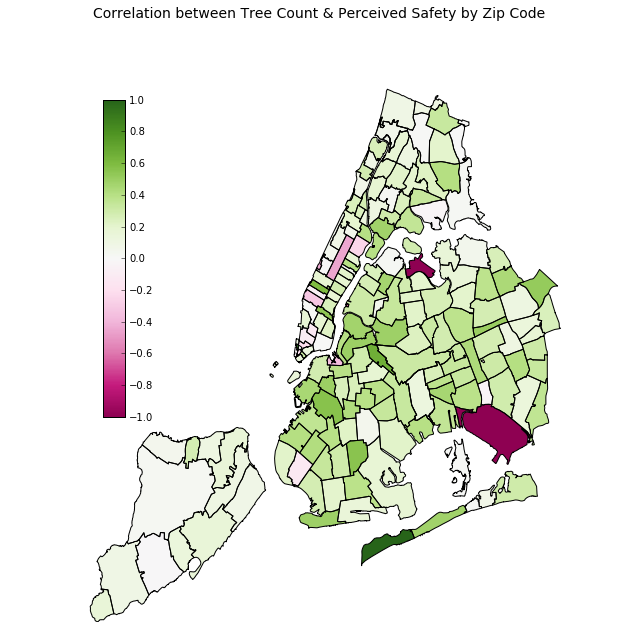

In [156]:
## Looking at correlation plotted by zip
fig3, ax3, cb3 = cp.choroplethNYC(overall, "corr", cmap="PiYG", cb=True)
fig3.suptitle('Correlation between Tree Count & Perceived Safety by Zip Code', fontsize=14)

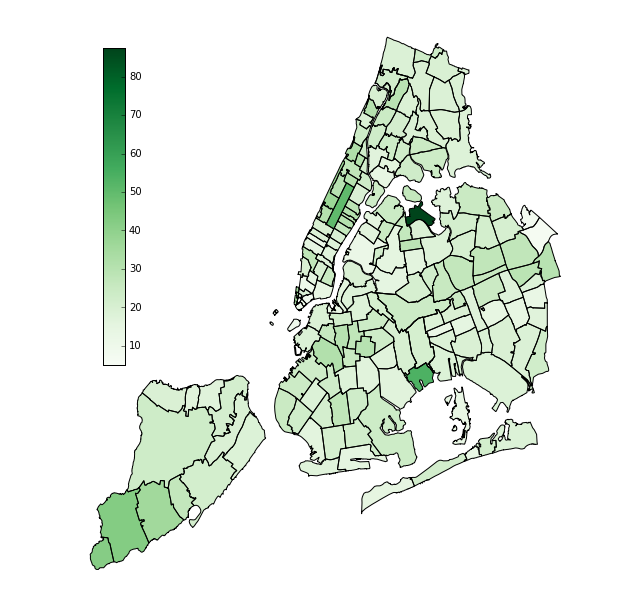

In [157]:
# Looking at tree count per block for each zip code
fig, ax, cb = cp.choroplethNYC(overall, "tree_count_by_zip", cmap="Greens", cb=True)

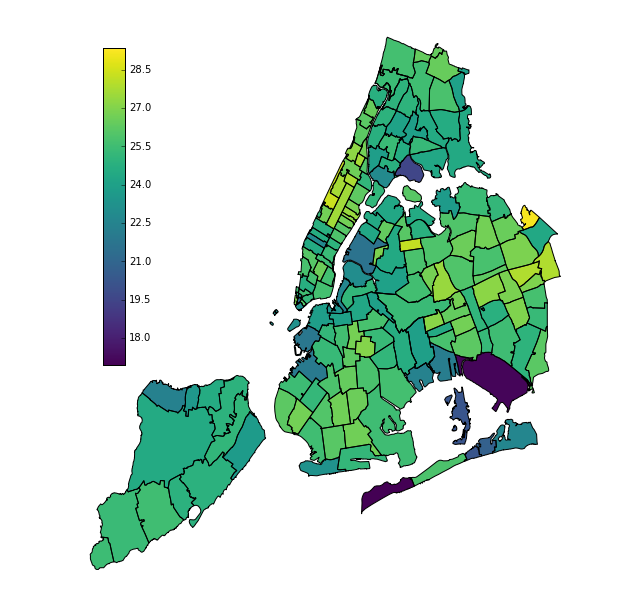

In [158]:
# Looking at average q_score for each zip code
fig, ax, cb = cp.choroplethNYC(overall, "q_score_by_zip", cmap="viridis", cb=True)

## Consider outliers

In [159]:
q_outliers = overall[np.abs(overall.q_score_by_zip-overall.q_score_by_zip.mean())>(3*overall.q_score_by_zip.std())]
tree_outliers = overall[np.abs(overall.tree_count_by_zip-overall.tree_count_by_zip.mean())>(3*overall.tree_count_by_zip.std())]

In [160]:
# Outliers for MIT SafetyScore
q_outliers[['zipcode','q_score_by_zip','corr','COUNTY','PO_NAME','POPULATION']]

,zipcode,q_score_by_zip,corr,COUNTY,PO_NAME,POPULATION
183,11430,17.116992,-1.0,Queens,Jamaica,16.0
190,11697,16.958545,1.0,Queens,Breezy Point,4079.0


In [161]:
# Outliers for tree per block
tree_outliers[['zipcode','tree_count_by_zip','corr','COUNTY','PO_NAME','POPULATION']]

,zipcode,tree_count_by_zip,corr,COUNTY,PO_NAME,POPULATION
58,83,50.4,-0.449244,New York,Central Park,25.0
99,11239,54.2,0.400482,Kings,Brooklyn,12562.0
191,11371,87.5,-1.000000,Queens,Flushing,0.0


The outliers for MIT Safety Score are JFK Airport (11430) and Fort Tilden Park (11697), while the outliers for trees per block are Central Park (83), LaGuardia Airport and half of Rikers Island (11371) and Gateway Center shopping center (11239). In order to get a more accurate picture of the relationship between tree count and perceived satety, I'm going to remove data points more than 3 standard deviations from the mean for each metric while plotting.

## Final Plots

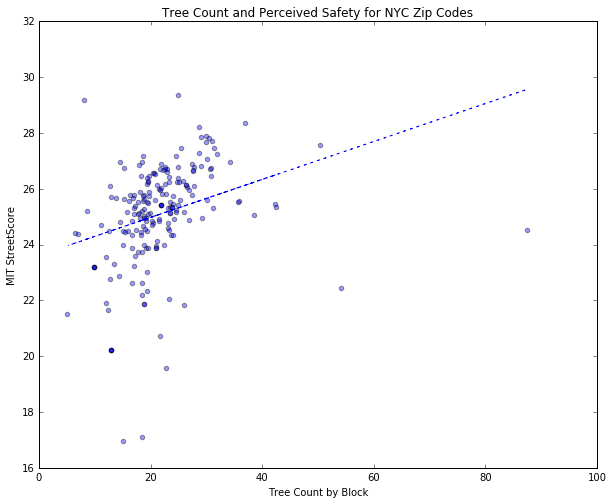

In [191]:
clean = overall[~overall.zipcode.isin(tree_outliers.zipcode + q_outliers.zipcode)]

def create_scatterplot(df,title): 
    
    # Create base scatterplot
    fig = plt.figure(figsize=(10,8))
    x = df['tree_count_by_zip']
    y = df['q_score_by_zip']

    # Add titles
    plt.title(title)
    plt.xlabel('Tree Count by Block')
    plt.ylabel('MIT StreetScore')

    # Add linear regression line
    m, b = np.polyfit(x,y,1)

    plt.scatter(x, y,alpha=0.4)
    plt.plot(x, m*x + b, '-.')
    plt.show()
    
create_scatterplot(clean,'Tree Count and Perceived Safety for NYC Zip Codes')

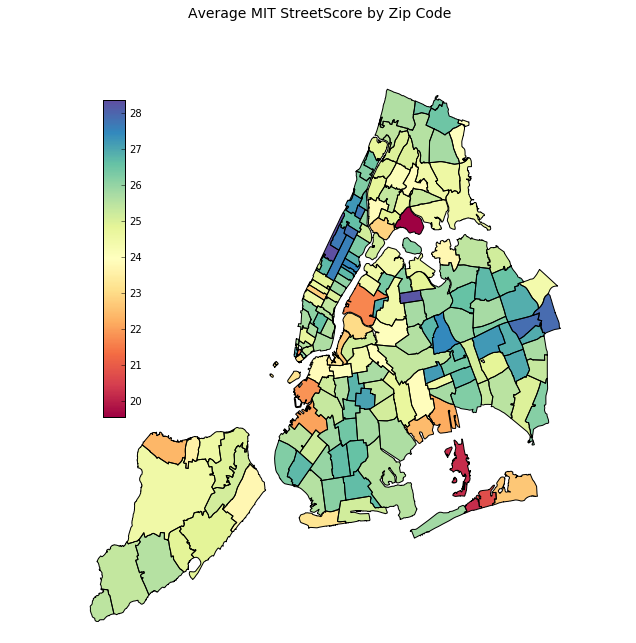

In [73]:
q_norm = overall[~overall.index.isin(q_outliers.index)].dropna()
fig, ax, cb = cp.choroplethNYC(q_norm, "q_score_by_zip", cmap="Spectral", cb=True)
fig.suptitle('Average MIT StreetScore by Zip Code', fontsize=14)

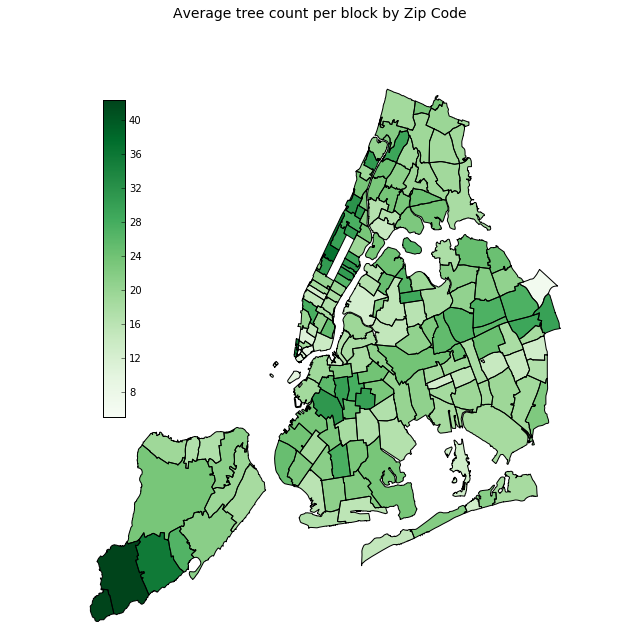

In [74]:
tree_norm = overall[~overall.index.isin(tree_outliers.index)].dropna()
fig_two, ax_two, cb_two = cp.choroplethNYC(tree_norm, "tree_count_by_zip", cmap="Greens", cb=True)
fig_two.suptitle('Average tree count per block by Zip Code', fontsize=14)